In [1]:
import torch
from torch import nn
import torch.optim as optim
from fastai.vision.all import *
import matplotlib.pyplot as plt
from my_models import VGG
from training_functions import *

In [2]:
in_channels = 3
out_channels = 10
device = "cuda:0"
net = VGG(in_channels = in_channels, 
            out_channels = out_channels,
            conv_blocks_out_size = [64,128,256,512,512],
            conv_blocks_amounts = [2,2,2,2,2],
            linear_layers_out_size = [200,200,out_channels])
net.to(device)

train_loss = nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

batch_size = 10
epoch_num = 10

In [4]:
path = URLs.IMAGENETTE_160

In [5]:
trainloader, valloader = prepare_train_and_val_dls(path, batch_size, size=160)

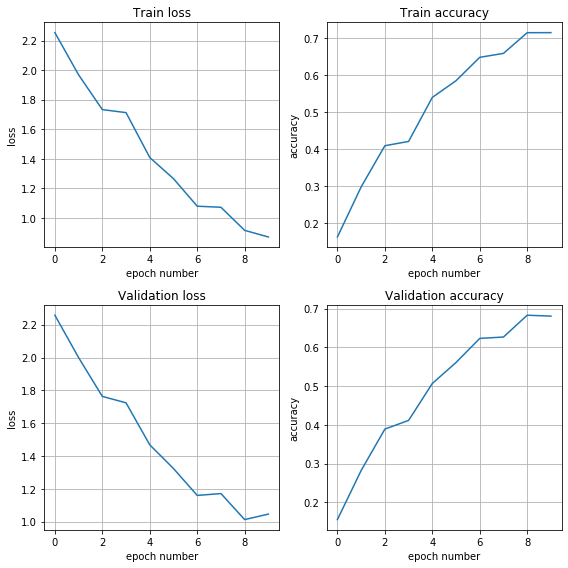

Current train loss: 0.869886
Current train accuracy: 0.715539
Current validation loss: 1.045789
Current validation accuracy: 0.680764
CPU times: user 5min 19s, sys: 3min 8s, total: 8min 28s
Wall time: 7min 52s


In [6]:
%%time
net, best_val_loss, best_val_acc, best_train_loss, best_train_acc = train(net, optimizer, train_loss, epoch_num, trainloader, valloader, device)

In [7]:
accuracy, conf_matrix, precision, recall, f1 = test_metrics(net, device, valloader, out_channels)

print("Test accuracy: ", accuracy)
print("Test precision: ", precision)
print("Test recall: ", recall)
print("Test f-measure: ", f1)

Test accuracy:  0.6807643312101911
Test precision:  0.4527278888512369
Test recall:  0.41044546850998465
Test f-measure:  0.4305510796003868


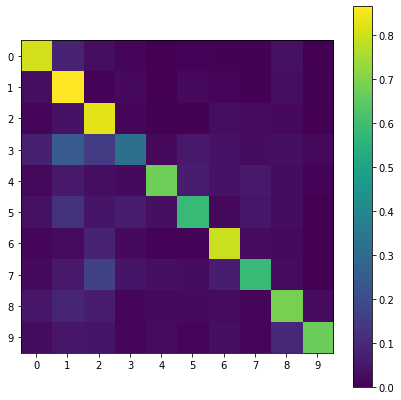

In [8]:
plt.figure(figsize=(7, 7))

plt.imshow(conf_matrix)
plt.xticks(range(conf_matrix.shape[0]))
plt.yticks(range(conf_matrix.shape[0]))
plt.colorbar()
plt.show()

In [17]:
data, labels = valloader.one_batch()

In [18]:
labels_names = ["tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"]

In [19]:
outputs = net(data)
_, predicted = torch.max(outputs.detach(), 1)

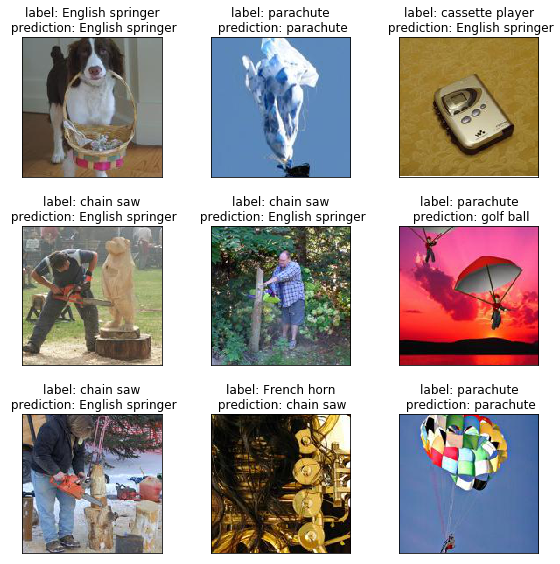

In [20]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8,8), subplot_kw={'xticks': [], 'yticks': []})

for picture_num, ax in enumerate(axs.flat):
    ax.imshow(data[picture_num].cpu().permute(1, 2, 0))
    ax.set_title("label: {}\n prediction: {}".format(labels_names[labels[picture_num]], 
                                                     labels_names[predicted[picture_num]]))

plt.tight_layout()
plt.show()